In [2]:
pip install zstandard python-chess


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 91.3 MB/s eta 0:00:00
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=a8b809bbd9b267d81d13f934f3768cf98124bf3a708348f03af89a07b9e45099
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [3]:
import zstandard as zstd

# Path to the compressed file
compressed_file = "lichess_db_standard_rated_2013-07.pgn.zst"
decompressed_file = "lichess_db_standard_rated_2013-07.pgn"

# Decompress the file
with open(compressed_file, "rb") as compressed, open(decompressed_file, "wb") as decompressed:
    dctx = zstd.ZstdDecompressor()
    dctx.copy_stream(compressed, decompressed)

print("Decompression complete!")


Decompression complete!


In [4]:
import chess.pgn
import pandas as pd

# Open the PGN file
pgn = open("lichess_db_standard_rated_2013-07.pgn")

# Prepare a list to store game data
data = []

# Iterate through the games
while True:
    game = chess.pgn.read_game(pgn)
    if game is None:  # End of file
        break

    # Extract metadata
    try:
        white_elo = int(game.headers.get("WhiteElo", 0))
        black_elo = int(game.headers.get("BlackElo", 0))
        result = game.headers.get("Result")
        opening = game.headers.get("Opening", "Unknown")
        termination = game.headers.get("Termination", "Unknown")
        moves = len(list(game.mainline_moves()))
    except ValueError:
        continue  # Skip games with missing or invalid data

    # Add to dataset
    data.append({
        "white_elo": white_elo,
        "black_elo": black_elo,
        "result": result,
        "opening": opening,
        "termination": termination,
        "total_moves": moves
    })

# Convert the data into a DataFrame
df = pd.DataFrame(data)

# Display the first few rows
print(df.head())

# Save data for future use
df.to_csv("chess_games.csv", index=False)


   white_elo  black_elo result                                 opening  \
0       1685       1577    0-1  Benoni Defense: Benoni Gambit Accepted   
1       1616       1421    1-0        French Defense: Knight Variation   
2       1629       2001    1-0                          Mieses Opening   
3       1562       1709    1-0                            Giuoco Piano   
4       1593       1761    0-1                     East Indian Defense   

    termination  total_moves  
0  Time forfeit           26  
1  Time forfeit           33  
2        Normal           83  
3  Time forfeit            9  
4        Normal           90  


In [5]:
# Load the data
df = pd.read_csv("chess_games.csv")

# Remove invalid or incomplete rows
df = df.dropna()

# Convert result to numeric (1 = White win, 0 = Draw, -1 = Black win)
df["result"] = df["result"].map({"1-0": 1, "0-1": -1, "1/2-1/2": 0})

# Filter for games within a specific Elo range (optional)
df = df[(df["white_elo"] >= 1000) & (df["white_elo"] <= 2000)]
df = df[(df["black_elo"] >= 1000) & (df["black_elo"] <= 2000)]

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 271830 entries, 0 to 293139
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   white_elo    271830 non-null  int64 
 1   black_elo    271830 non-null  int64 
 2   result       271830 non-null  int64 
 3   opening      271830 non-null  object
 4   termination  271830 non-null  object
 5   total_moves  271830 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB
None


In [6]:
# Extract useful features
df["elo_difference"] = df["white_elo"] - df["black_elo"]
df["is_white_higher_rated"] = (df["white_elo"] > df["black_elo"]).astype(int)

# One-hot encode openings
df_openings = pd.get_dummies(df["opening"], prefix="opening")
df = pd.concat([df, df_openings], axis=1)

# Drop unused columns
df = df.drop(["opening", "termination"], axis=1)

print(df.head())

   white_elo  black_elo  result  total_moves  elo_difference  \
0       1685       1577      -1           26             108   
1       1616       1421       1           33             195   
3       1562       1709       1            9            -147   
4       1593       1761      -1           90            -168   
5       1353       1270      -1           68              83   

   is_white_higher_rated  opening_Alekhine Defense  \
0                      1                     False   
1                      1                     False   
3                      0                     False   
4                      0                     False   
5                      1                     False   

   opening_Alekhine Defense #2  opening_Alekhine Defense #3  \
0                        False                        False   
1                        False                        False   
3                        False                        False   
4                        False        

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data
X = df.drop("result", axis=1)  # Features
y = df["result"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[23189   130 13832]
 [ 1344    58  1318]
 [12411   126 29141]]
              precision    recall  f1-score   support

          -1       0.63      0.62      0.63     37151
           0       0.18      0.02      0.04      2720
           1       0.66      0.70      0.68     41678

    accuracy                           0.64     81549
   macro avg       0.49      0.45      0.45     81549
weighted avg       0.63      0.64      0.63     81549



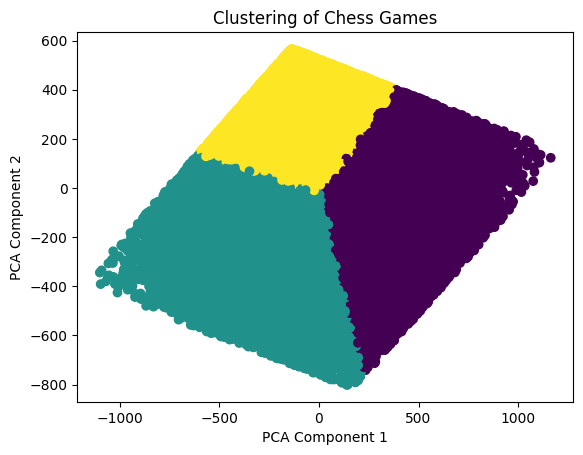

In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Select features for clustering
X_cluster = df[["white_elo", "black_elo", "elo_difference", "total_moves"]]

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_cluster)

# Visualize clusters using PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_cluster)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["cluster"], cmap="viridis")
plt.title("Clustering of Chess Games")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [10]:
# Cluster labels are already assigned in df["cluster"]
print(df.groupby("cluster").mean())  # View the average values of features in each cluster


           white_elo    black_elo    result  total_moves  elo_difference  \
cluster                                                                    
0        1600.586780  1400.517073  0.423961    61.941412      200.069706   
1        1403.848860  1560.135421 -0.266663    63.501336     -156.286561   
2        1744.313422  1746.243385  0.032360    72.859595       -1.929963   

         is_white_higher_rated  opening_Alekhine Defense  \
cluster                                                    
0                     1.000000                  0.002484   
1                     0.079387                  0.001658   
2                     0.504433                  0.001030   

         opening_Alekhine Defense #2  opening_Alekhine Defense #3  \
cluster                                                             
0                           0.000487                     0.000024   
1                           0.000311                     0.000081   
2                           0.000447      

In [11]:
print(df["cluster"].value_counts())


cluster
2    102874
1     86840
0     82116
Name: count, dtype: int64


In [12]:
cluster_summary = df.groupby("cluster").agg({
    "white_elo": ["mean", "std"],
    "black_elo": ["mean", "std"],
    "total_moves": ["mean", "std"],
    "elo_difference": ["mean", "std"]
})
print(cluster_summary)


           white_elo                black_elo             total_moves  \
                mean         std         mean         std        mean   
cluster                                                                 
0        1600.586780  146.767017  1400.517073  127.959229   61.941412   
1        1403.848860  121.457033  1560.135421  146.111520   63.501336   
2        1744.313422  108.072583  1746.243385  105.927761   72.859595   

                   elo_difference              
               std           mean         std  
cluster                                        
0        31.746337     200.069706  134.442988  
1        32.172424    -156.286561  139.550509  
2        32.419511      -1.929963  122.098270  


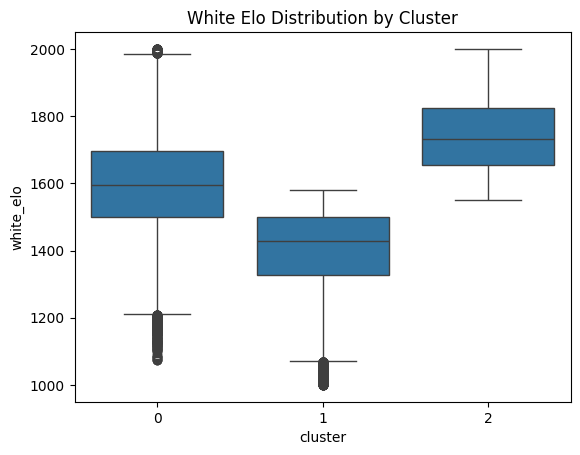

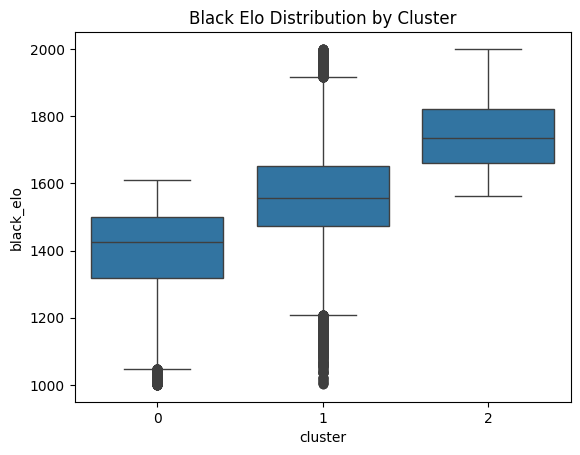

In [16]:
import seaborn as sns

sns.boxplot(x="cluster", y="white_elo", data=df)
plt.title("White Elo Distribution by Cluster")
plt.show()

sns.boxplot(x="cluster", y="black_elo", data=df)
plt.title("Black Elo Distribution by Cluster")
plt.show()


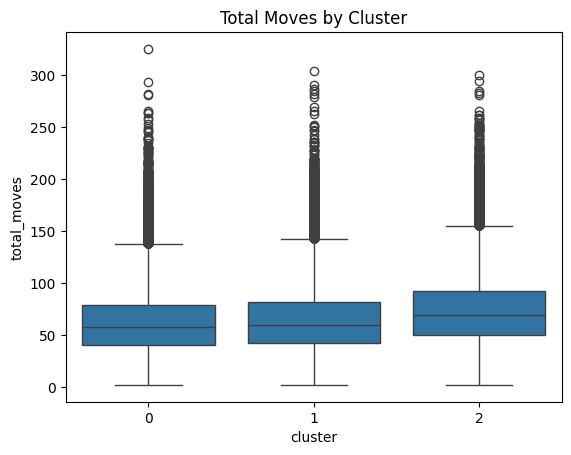

In [17]:
sns.boxplot(x="cluster", y="total_moves", data=df)
plt.title("Total Moves by Cluster")
plt.show()


In [18]:
# Map cluster numbers to descriptive labels
cluster_labels = {
    0: "One-Sided Games",
    1: "Balanced Games",
    2: "Complex High-Level Games"
}
df["cluster_label"] = df["cluster"].map(cluster_labels)

print(df[["cluster", "cluster_label"]].head())


   cluster             cluster_label
0        2  Complex High-Level Games
1        0           One-Sided Games
3        1            Balanced Games
4        2  Complex High-Level Games
5        0           One-Sided Games


In [9]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print(feature_importance)

                                                Feature  Importance
3                                        elo_difference    0.170064
2                                           total_moves    0.159998
0                                             white_elo    0.137823
1                                             black_elo    0.137698
4                                 is_white_higher_rated    0.036845
...                                                 ...         ...
1025   opening_Lion Defense: Anti-Philidor, Lion's Cave    0.000000
246          opening_Caro-Kann Defense: Spike Variation    0.000000
867   opening_King's Gambit, Falkbeer Countergambit,...    0.000000
868   opening_King's Gambit, Falkbeer Countergambit,...    0.000000
211   opening_Caro-Kann Defense: Classical Variation...    0.000000

[2164 rows x 2 columns]
